# Toxicity signal analysis


In [1]:
from datasets import load_dataset
import cohere
import numpy as np
import os
import gcsfs

dataset = 'jigsaw_toxicity_pred'
storage_options = {"token": "anon"}
fs = gcsfs.GCSFileSystem(**storage_options)
remote_dir = 'gs://lilac-data-us-east1/datasets/jigsaw_toxicity_pred/'
local_dir = os.path.join('gcs_cache', 'local_cache', 'datasets', dataset)

if not os.path.exists(local_dir):
  print('Downloading dataset from GCS...')
  fs.download(remote_dir, local_dir, recursive=True)

EMBEDDING_MODEL = 'large'
BATCH_SIZE = 96
TEMPLATE = '{}'
co = cohere.Client(os.environ['COHERE_API_KEY'])
train_data = load_dataset(dataset, data_dir=local_dir, split='train[:40%]')
test_data = load_dataset(dataset, data_dir=local_dir, split='test[:40%]')


/Users/dsmilkov/code/lilac/.venv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Found cached dataset jigsaw_toxicity_pred (/Users/dsmilkov/.cache/huggingface/datasets/jigsaw_toxicity_pred/default-5db8a327f2bff2c8/1.1.0/9cf096ac4341c35839bc8a9f6a19d93e18e5ad3d84cf05f690d2bc6f7384af85)
Found cached dataset jigsaw_toxicity_pred (/Users/dsmilkov/.cache/huggingface/datasets/jigsaw_toxicity_pred/default-5db8a327f2bff2c8/1.1.0/9cf096ac4341c35839bc8a9f6a19d93e18e5ad3d84cf05f690d2bc6f7384af85)


In [2]:
from sklearn.preprocessing import normalize


def compute_embedding(texts: list[str]) -> np.ndarray:
  """Compute cohere embeddings for a list of texts."""
  texts = [TEMPLATE.replace('{}', text) for text in texts]
  cohere_embeddings = co.embed(texts, truncate='END', model=EMBEDDING_MODEL).embeddings
  return np.array(cohere_embeddings)


def get_embeddings(dataset) -> np.ndarray:
  fname = os.path.join(local_dir,
                       f'{dataset.builder_name}_{dataset.split}_{EMBEDDING_MODEL}_embeddings.npy')
  try:
    embeddings = np.load(fname)
  except FileNotFoundError:
    data = dataset.map(lambda batch: {'x': compute_embedding(batch['comment_text'])},
                       batched=True,
                       batch_size=BATCH_SIZE)
    embeddings = np.array(data['x'])
    np.save(fname, embeddings)

  embeddings = normalize(embeddings).astype(np.float16)
  return embeddings

### Compute the embeddings


In [3]:
def make_balanced_data(data, embeddings, sample_size_per_group):
  df = data.to_pandas()
  groups = df['toxic'].groupby(df['toxic']).groups
  positive_examples = groups[1][:sample_size_per_group]
  negative_examples = groups[0][:sample_size_per_group]
  positive_embeddings = embeddings[positive_examples]
  negative_embeddings = embeddings[negative_examples]
  positive_labels = np.ones(len(positive_embeddings))
  negative_labels = np.zeros(len(negative_embeddings))
  positive_text = df.loc[positive_examples]['comment_text']
  negative_text = df.loc[negative_examples]['comment_text']
  embeddings = np.concatenate([positive_embeddings, negative_embeddings])
  labels = np.concatenate([positive_labels, negative_labels])
  text = np.concatenate([positive_text, negative_text])
  return embeddings, labels, text

In [4]:
from sklearn.linear_model import LogisticRegression

train_embeddings = get_embeddings(train_data)
test_embeddings = get_embeddings(test_data)

model = LogisticRegression(class_weight='balanced', C=30, tol=1e-5, warm_start=True, max_iter=1_000)

## Train a model


In [5]:
from sklearn.metrics import roc_auc_score

from src.utils import DebugTimer

SAMPLE_SIZE_PER_GROUP = 512
embeddings, labels, texts = make_balanced_data(train_data, train_embeddings, SAMPLE_SIZE_PER_GROUP)
with DebugTimer('Training a model'):
  model.fit(embeddings, labels)

roc_auc = roc_auc_score(labels, model.predict_proba(embeddings)[:, 1])
print(f'ROC AUC on train set, {len(embeddings)} examples: {roc_auc:.3f}')

test_labels = np.array(test_data['toxic'])
roc_auc = roc_auc_score(test_labels, model.predict_proba(test_embeddings)[:, 1])
print(f'ROC AUC on test set, {len(test_labels)} examples: {roc_auc:.3f}')
accuracy = model.score(test_embeddings, test_labels)
print(f'Accuracy on test set, {len(test_labels)} examples: {accuracy:.3f}')

Training a model took 0.826s.
ROC AUC on train set, 1024 examples: 1.000
ROC AUC on test set, 25591 examples: 0.934
Accuracy on test set, 25591 examples: 0.865


## Save the concept


In [25]:
from src.concepts.concept import Concept, Example

data = {}

for index, (label, text) in enumerate(zip(labels, texts)):
  id = str(index)
  ex = Example(label=bool(label), text=text, id=str(index))
  data[id] = ex

concept = Concept(namespace='local', concept_name='toxicity', type='text', data=data)

with open('gcs_cache/concept/local/toxicity/concept.json', 'w') as f:
  f.write(concept.json(exclude_none=True, exclude_unset=True, indent=2))

(array([351.,  53.,  56.,  14.,  12.,  13.,   3.,   6.,   3.,   1.,   1.,
          2.,   4.,   7.,  10.,  14.,  21.,  39.,  76., 338.]),
 array([2.52187127e-05, 5.00237513e-02, 1.00022284e-01, 1.50020816e-01,
        2.00019349e-01, 2.50017881e-01, 3.00016414e-01, 3.50014947e-01,
        4.00013479e-01, 4.50012012e-01, 5.00010544e-01, 5.50009077e-01,
        6.00007609e-01, 6.50006142e-01, 7.00004674e-01, 7.50003207e-01,
        8.00001739e-01, 8.50000272e-01, 8.99998805e-01, 9.49997337e-01,
        9.99995870e-01]),
 <BarContainer object of 20 artists>)

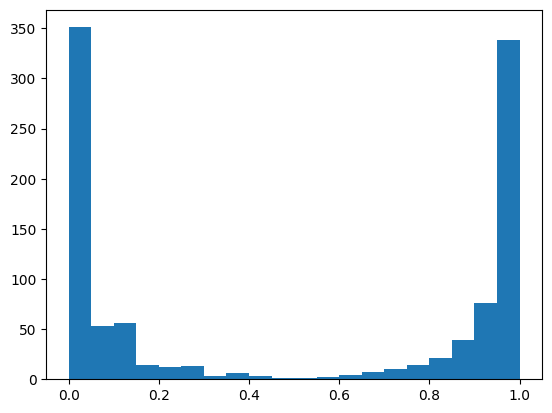

In [26]:
import matplotlib.pyplot as plt

%matplotlib inline
plt.hist(model.predict_proba(embeddings)[:, 1], bins=20)

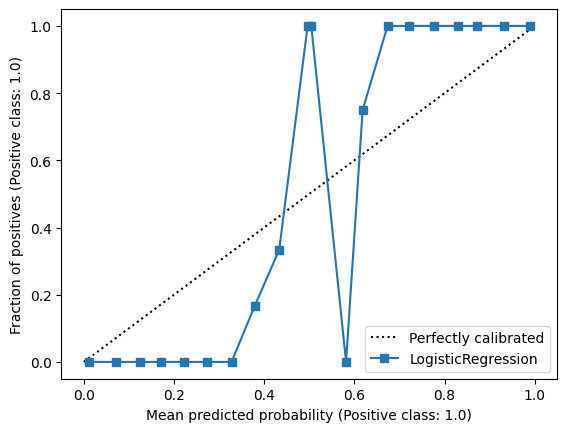

In [27]:
from sklearn.calibration import CalibrationDisplay
import matplotlib.pyplot as plt

CalibrationDisplay.from_estimator(model, embeddings, labels, n_bins=20)
plt.show()